In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix, fbeta_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

Need to train and test models on metrics thinking precision, recall, f1, f2, roc-auc, confusion matrix, auc-pr.

Pretty heavy class imbalance with 
Melanoma: 234 images
BCC: 594 images
SCC: 365 images
Actinic Keratosis: 176 images
Benign_or_Other: 1786 images 
Total: 3155 

So lower classes we need to augment them much heavier than benign and focal loss so model doesn't over focus on benign cases and lose focus on smaller cases.

In [2]:
#intialize the resnet50
resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#other models are vit_b_16, ViT_B_16_Weights, convnext_base, ConvNeXt_Base_Weights, swin_v2_b, Swin_V2_B_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights

In [3]:
# Focal Loss implementation from https://github.com/itakurah/focal-loss-pytorch/blob/main/focal_loss.py 
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [4]:
data_dir = "../DataCleaning/Sorted_Images"
batch_size = 32
learning_rate = 0.001
num_epochs = 15
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}") #WTF 

Using cuda


In [5]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available:  {torch.cuda.is_available()}")

PyTorch Version: 2.5.1+cu121
CUDA Available:  True


In [6]:
# might need to change around these transforms 
training_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# do not augment validation images
val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
full_dataset = ImageFolder(root=data_dir, transform=training_transform)

In [8]:
train_size = int(0.80 * len(full_dataset)) #80% train
val_size = int(0.10 * len(full_dataset)) #10%
test_size = len(full_dataset) - train_size - val_size #10
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [9]:
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

In [10]:
print(f"Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Train=2524, Val=315, Test=316


In [11]:
# we use multi class -> 5 classes, alpha = class weights for focal loss calculated by weight_class = total_samples / (num_classes x total_class_count)
# AK = 3155 / (5 x 176)
#    = 3.585 for example, so its weighted the heaviest due to it having the least amount of entries in our data
# Benign = 3155 / (5 x 1786)
#        = 0.353

class_counts = {
    0: 176,   # Actinic Keratosis
    1: 594,   # BCC
    2: 1786,  # Benign or Other
    3: 234,   # Melanoma
    4: 365    # SCC
}

num_classes = 5
total_samples = sum(class_counts.values())

# calculate class weights (inverse frequency)
class_weights = []
for i in range(num_classes):
    weight = total_samples / (num_classes * class_counts[i]) # 
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("class weights calculated:")
for i, weight in enumerate(class_weights):
    print(f"  Class {i}: {weight:.4f} (count: {class_counts[i]})")
    

class weights calculated:
  Class 0: 3.5852 (count: 176)
  Class 1: 1.0623 (count: 594)
  Class 2: 0.3533 (count: 1786)
  Class 3: 2.6966 (count: 234)
  Class 4: 1.7288 (count: 365)


In [12]:
# loading time 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# freeze the model since we dont want to touch weights 
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet_model.fc.in_features, num_classes)
)
resnet_model = resnet_model.to(device)

In [14]:
# focal loss 
criterion = FocalLoss(gamma=2.0, alpha=class_weights_tensor, task_type='multi-class', num_classes=num_classes) #alpha = none because the random sampler is already balancing the data 
#criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # ^ uncomment for focal. 
# balanced learning rate and weight decay
optimizer = torch.optim.Adam(resnet_model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)

In [15]:
# please fix validation
reduce_lr = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4)

In [16]:
def model_evaluation(model, test_loader, device, class_names):
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # calculate metrics 
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    f2 = fbeta_score(y_true, y_pred, beta=2, average=None)

    metrics_ds = pd.DataFrame({
        "Class": class_names,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "F2 Score": f2,
        "Support": support
    })

    print(metrics_ds.round(4).to_string(index=False))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix")

    # auc curves 
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        plt.plot(recall_curve, precision_curve, lw=2, label=f"{class_names[i]} (Average Precision = {ap:2f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="best")
    plt.grid(alpha=0.2)
    plt.show()

In [17]:
# training time 
for epoch in range(num_epochs):

    resnet_model.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    reduce_lr.step(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Gap: {train_acc - val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}\n")

Epoch [1/15] Batch [10/79] Loss: 0.2477 Acc: 32.81%
Epoch [1/15] Batch [20/79] Loss: 0.1719 Acc: 26.25%
Epoch [1/15] Batch [30/79] Loss: 0.3081 Acc: 23.65%
Epoch [1/15] Batch [40/79] Loss: 0.1931 Acc: 27.58%
Epoch [1/15] Batch [50/79] Loss: 0.2316 Acc: 31.25%
Epoch [1/15] Batch [60/79] Loss: 0.1425 Acc: 32.19%
Epoch [1/15] Batch [70/79] Loss: 0.1559 Acc: 32.77%

Epoch [1/15] Summary:
  Train Loss: 0.1990 | Train Acc: 32.65%
  Val Loss: 0.1940 | Val Acc: 36.83%
  Gap: -4.18% | LR: 1.00e-03

Epoch [2/15] Batch [10/79] Loss: 0.1515 Acc: 39.38%
Epoch [2/15] Batch [20/79] Loss: 0.1463 Acc: 42.34%
Epoch [2/15] Batch [30/79] Loss: 0.1570 Acc: 42.92%
Epoch [2/15] Batch [40/79] Loss: 0.1513 Acc: 41.80%
Epoch [2/15] Batch [50/79] Loss: 0.1747 Acc: 41.62%
Epoch [2/15] Batch [60/79] Loss: 0.1776 Acc: 41.46%
Epoch [2/15] Batch [70/79] Loss: 0.2334 Acc: 41.70%

Epoch [2/15] Summary:
  Train Loss: 0.1749 | Train Acc: 41.09%
  Val Loss: 0.1889 | Val Acc: 29.21%
  Gap: 11.88% | LR: 1.00e-03

Epoch [3/1

            Class  Precision  Recall  F1 Score  F2 Score  Support
Actinic Keratosis     0.2571  0.5294    0.3462    0.4369       17
              BCC     0.3205  0.4464    0.3731    0.4139       56
  Benign_or_Other     0.7961  0.4659    0.5878    0.5081      176
         Melanoma     0.1277  0.2500    0.1690    0.2098       24
              SCC     0.4151  0.5116    0.4583    0.4889       43


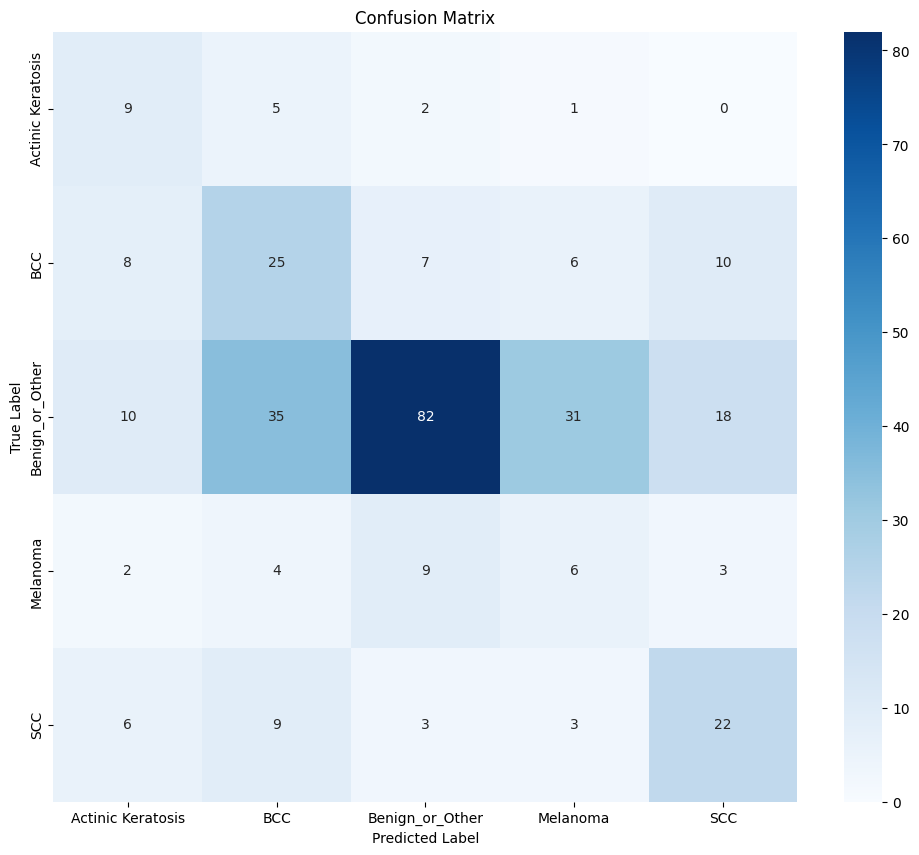

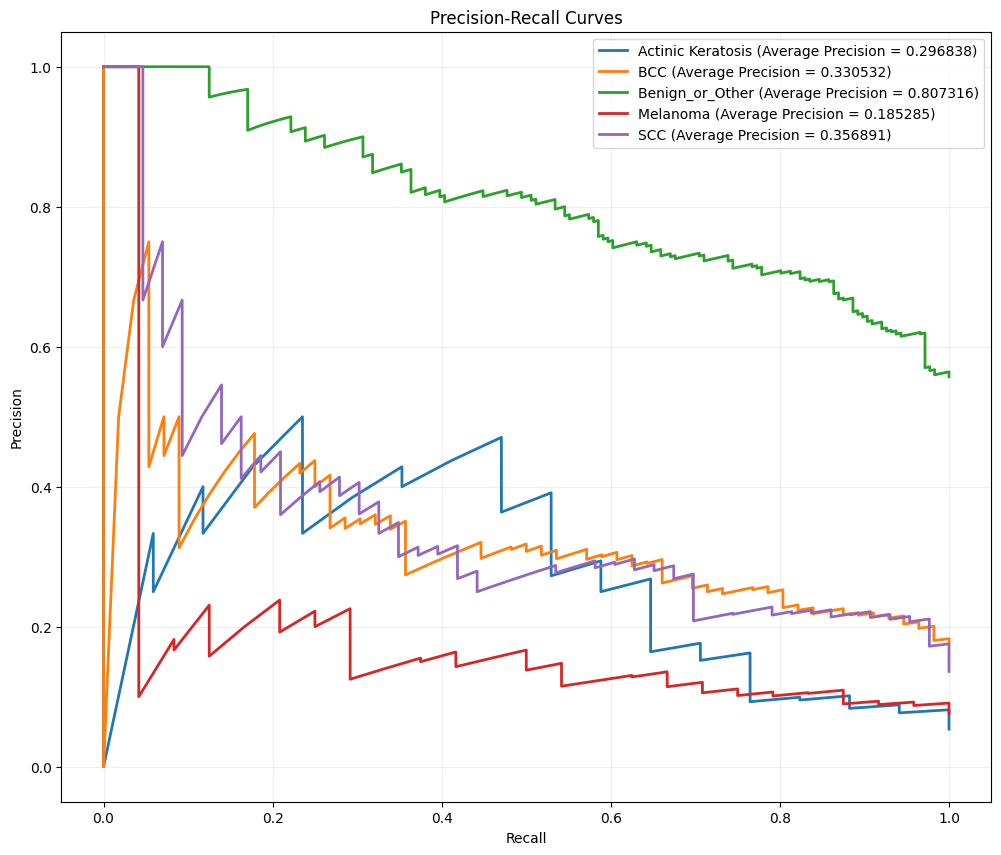

In [18]:
model_evaluation(resnet_model, test_loader, device, full_dataset.classes)

In [19]:
#unfreeze layer 4 to finetune
for param in resnet_model.layer4.parameters():
    param.requires_grad = True

In [21]:
retrain_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-5, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [22]:
# training time 
fine_tune_epochs = 15
for epoch in range(fine_tune_epochs): 

    resnet_model.train()
    train_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # forward pass 
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        #backward pass
        retrain_optimizer.zero_grad()
        loss.backward()
        retrain_optimizer.step()

        #stats
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{fine_tune_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} Acc: {100.*correct/total:.2f}%")
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total 

    #validation
    resnet_model.eval()
    val_loss = 0.0
    correct = 0 
    total = 0 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    reduce_lr.step(val_acc)

    print(f"\nEpoch [{epoch+1}/{fine_tune_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Gap: {train_acc - val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.2e}\n")

Epoch [1/15] Batch [10/79] Loss: 0.0928 Acc: 54.69%
Epoch [1/15] Batch [20/79] Loss: 0.1340 Acc: 52.81%
Epoch [1/15] Batch [30/79] Loss: 0.1533 Acc: 53.12%
Epoch [1/15] Batch [40/79] Loss: 0.1114 Acc: 53.20%
Epoch [1/15] Batch [50/79] Loss: 0.1073 Acc: 53.25%
Epoch [1/15] Batch [60/79] Loss: 0.1122 Acc: 53.70%
Epoch [1/15] Batch [70/79] Loss: 0.0763 Acc: 53.93%

Epoch [1/15 Summary:
  Train Loss: 0.1169 | Train Acc: 53.72%
  Val Loss: 0.1932 | Val Acc: 45.71%
  Gap: 8.01% | LR: 1.00e-05

Epoch [2/15] Batch [10/79] Loss: 0.1129 Acc: 54.69%
Epoch [2/15] Batch [20/79] Loss: 0.1241 Acc: 56.88%
Epoch [2/15] Batch [30/79] Loss: 0.1107 Acc: 57.40%
Epoch [2/15] Batch [40/79] Loss: 0.0747 Acc: 56.09%
Epoch [2/15] Batch [50/79] Loss: 0.0892 Acc: 55.56%
Epoch [2/15] Batch [60/79] Loss: 0.1225 Acc: 55.57%
Epoch [2/15] Batch [70/79] Loss: 0.1797 Acc: 54.91%

Epoch [2/15 Summary:
  Train Loss: 0.1144 | Train Acc: 54.99%
  Val Loss: 0.1927 | Val Acc: 46.67%
  Gap: 8.33% | LR: 1.00e-05

Epoch [3/15] B

            Class  Precision  Recall  F1 Score  F2 Score  Support
Actinic Keratosis     0.3913  0.5294    0.4500    0.4945       17
              BCC     0.3333  0.5000    0.4000    0.4545       56
  Benign_or_Other     0.7656  0.5568    0.6447    0.5889      176
         Melanoma     0.1613  0.2083    0.1818    0.1969       24
              SCC     0.3800  0.4419    0.4086    0.4279       43


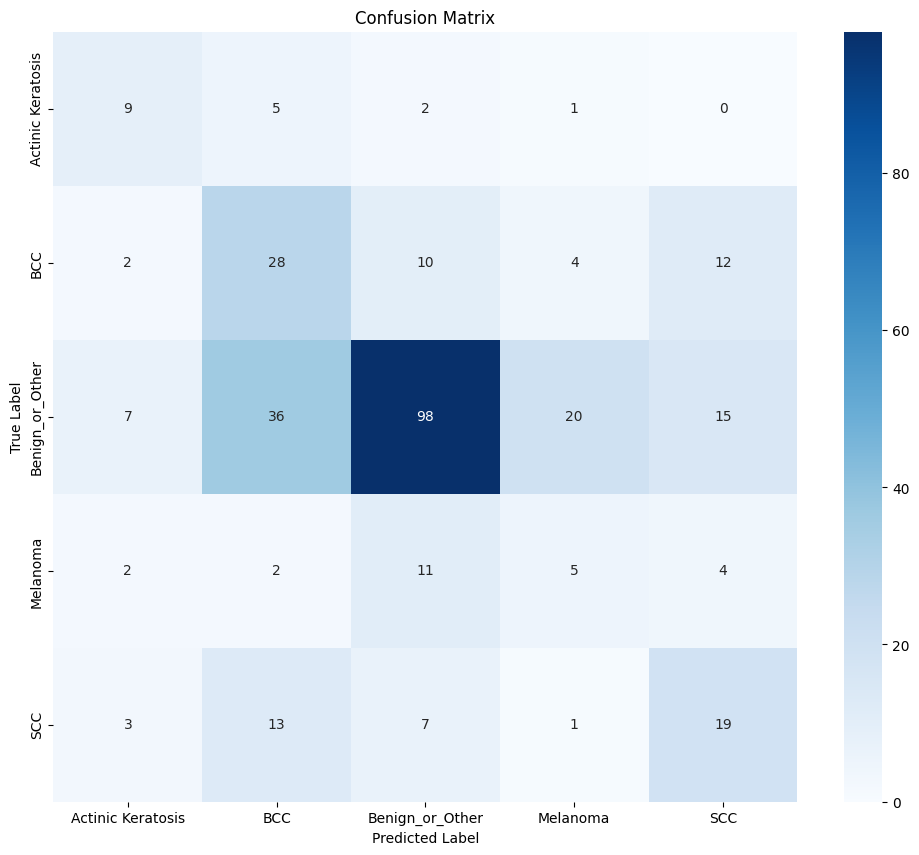

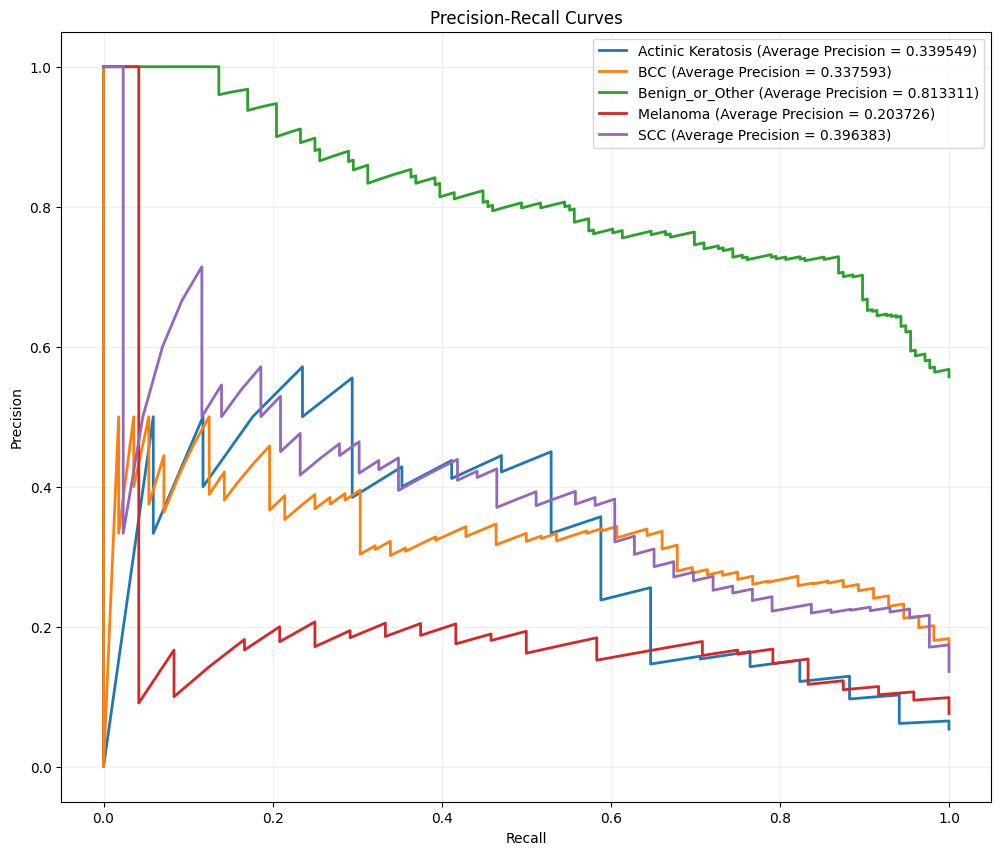

In [24]:
model_evaluation(resnet_model, test_loader, device, full_dataset.classes)

I have came to the conclusion that resnet is horrible for this type of dataset as resnet uses GAP (global average pooling) layers and the images often have background or random stuff in the images so the model gets stunted from these images. I think ViT and Swin will do a better job for the dataset.  